# Assignment 4

#### Student ID: *M124111043*

#### Name: *唐嘉宏*

## Q1: Transfer Learning on the Dataset Used by the CNN Explainer

[CNN Explainer](https://poloclub.github.io/cnn-explainer/) is an interactive, open-source visualization tool designed to provide a comprehensive understanding of Convolutional Neural Networks (CNNs). In the last assignment, we attempted to replicate the original experiment using TinyVGG by training the model from scratch. However, the results were not satisfactory. In this exercise, we will continue our work and leverage transfer learning to improve performance on the test dataset. First, load the dataset using the following code (feel free to modify the code if you prefer to use PyTorch or other frameworks).

To ensure reproducibility, please set all the random seeds to 2024:

In [1]:
!gdown --fuzzy https://drive.google.com/file/d/1DvyriY4ehA56Bj3asAbCz_syYZvTkumW/view?usp=sharing
!unzip cnn_data.zip

'gdown' ���O�����Υ~���R�O�B�i���檺�{���Χ妸�ɡC
'unzip' ���O�����Υ~���R�O�B�i���檺�{���Χ妸�ɡC


In [3]:
import numpy as np
import tensorflow as tf
import random
from tensorflow.keras.utils import image_dataset_from_directory


In [4]:
seed = 2024
training_images = 'train_images/'
vali_images = 'val_images/'
test_images = 'test_images/'

train_dataset = image_dataset_from_directory(
    training_images,
    image_size=(64, 64),
    shuffle=True,
    batch_size=32,
    seed=seed)
validation_dataset = image_dataset_from_directory(
    vali_images,
    image_size=(64, 64),
    shuffle=False,
    batch_size=32)
test_dataset = image_dataset_from_directory(
    test_images,
    image_size=(64, 64),
    shuffle=False,
    batch_size=32)

Found 5000 files belonging to 10 classes.
Found 250 files belonging to 10 classes.
Found 250 files belonging to 10 classes.


#### (a) EfficientNet is a modern convolutional neural network obtained through [network architecture search](https://lilianweng.github.io/posts/2020-08-06-nas/). We will use it to perform transfer learning by following the procedure below: (10%)

1. Add a callback to monitor the validation loss and save the best model based on the validation loss.

2. Import the convolutional base of [`EfficientNetV2Backbone`](https://keras.io/api/keras_cv/models/backbones/efficientnetv2/) (`efficientnetv2_b0`) with pre-trained weights from ImageNet. Freeze all the weights in the convolutional base.

3. Add a dropout layer after the convolutional base (remember to flatten the output of the base before applying dropout) with a dropout rate of 0.5, followed by a dense layer with softmax activation to classify the 10 classes.

4. Train the model for 10 epochs using the [`Nadam`](https://keras.io/api/optimizers/Nadam/) optimizer with the default learning rate. Finally, report the accuracy on the test set. Remember to reload the best model before testing.

In [7]:
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras import layers, models, callbacks

# 1. 添加回調函數
checkpoint_path = "best_model.keras"
checkpoint_callback = callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)
# 2. 匯入 EfficientNetV2B0
conv_base = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
conv_base.trainable = False  # 凍結卷積基座

# 3. 添加 dropout 層和全連接層
model = models.Sequential([
    conv_base,
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')  # 10 類分類
])

# 編譯模型
model.compile(optimizer='nadam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 4. 訓練模型
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10,
    callbacks=[checkpoint_callback]
)

# 重新加載最佳模型
model.load_weights(checkpoint_path)

# 評估測試集準確率
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy}")


24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 66ms/step - accuracy: 0.6299 - loss: 1.1937 - val_accuracy: 0.8920 - val_loss: 0.3076
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.9204 - loss: 0.2571 - val_accuracy: 0.9080 - val_loss: 0.2480
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.9554 - loss: 0.1670 - val_accuracy: 0.9120 - val_loss: 0.2309
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.9602 - loss: 0.1313 - val_accuracy: 0.9160 - val_loss: 0.2284
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.9655 - loss: 0.1118 - val_accuracy: 0.9120 - val_loss: 0.2150
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.9798 - loss: 0.0836 - val_accuracy: 0.9240 - val_loss: 0.2183
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.9842 - loss: 0.0749 - val_accuracy: 0.9160 - val_loss: 0.2109
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 52

#### (b) Contrastive Language-Image Pre-Training (CLIP) is a foundational model that includes both text and image encoders. Its multimodal nature enables zero-shot classification. In this problem, we will leverage [`CLIP`](https://huggingface.co/docs/transformers/model_doc/clip) to perform classification. (10%)

1. Load the model and processor using the checkpoint [`openai/clip-vit-base-patch32`](https://huggingface.co/openai/clip-vit-base-patch32) from Hugging Face.

2. Use the following list as the candidate text labels:
    ```
    ['boat',
     'bug',
     'bus',
     'car',
     'espresso',
     'koala',
     'orange',
     'panda',
     'pepper',
     'pizza']
    ```

3. Perform zero-shot 10-class classification using the processor and the `CLIP` model on the test dataset.

4. Calculate the accuracy on the test dataset.

**Hint:** Refer to our lab to learn how to perform zero-shot classification. Remember that you can extract the image data and labels from the test set into `X` and `y` `NumPy` arrays.

In [8]:
# coding your answer here.
from transformers import CLIPProcessor, CLIPModel
import numpy as np
import torch

# 加載 CLIP 模型和處理器
model_name = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

c:\Users\User\anaconda3\envs\datascience\lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\User\.cache\huggingface\hub\models--openai--clip-vit-base-patch32. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [9]:
labels = [
    "boat", "bug", "bus", "car", "espresso", 
    "koala", "orange", "panda", "pepper", "pizza"
]

# 構建文本嵌入
text_inputs = processor(
    text=labels, return_tensors="pt", padding=True
).to("cuda" if torch.cuda.is_available() else "cpu")


In [10]:
# 提取圖像數據和標籤
X, y = [], []
for images, labels in test_dataset:
    X.extend(images.numpy())
    y.extend(labels.numpy())

X = np.array(X)  # 圖像數據
y = np.array(y)  # 標籤


In [11]:
correct = 0

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

for i, image in enumerate(X):
    # 將圖像處理為模型輸入格式
    image_input = processor(
        images=image, return_tensors="pt"
    ).to(device)

    # 獲取圖像和文本嵌入
    image_features = model.get_image_features(**image_input)
    text_features = model.get_text_features(**text_inputs)

    # 計算相似度
    logits = torch.matmul(image_features, text_features.T)
    predicted_class = logits.argmax(dim=1).item()

    # 檢查是否分類正確
    if predicted_class == y[i]:
        correct += 1

# 計算準確率
accuracy = correct / len(y)
print(f"Test Accuracy: {accuracy:.2%}")


Test Accuracy: 74.00%


#### (c) [Stable Diffusion](https://huggingface.co/blog/stable_diffusion) is a text-to-image model that can generate high-quality images using a diffusion model. Design a prompt (e.g., "a photo of ...") to generate three realistic photos that belong to one of the given 10 classes in the CNN Explainer (e.g., koala, bug) using `diffusers` or `KerasCV`. Finally, plot the three generated images. Additionally, resize the three images you generate into $64 \times 64$ pixels. (10%)

**Hint:** You can use `PIL`, `OpenCV`, `Skimage`, or even `NumPy` to resize the images.

In [12]:
# coding your answer here.
from diffusers import StableDiffusionPipeline
import torch
from PIL import Image
import matplotlib.pyplot as plt

# 加載 Stable Diffusion 模型
device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5").to(device)

# 設計提示詞（例如，koala, bug）
prompts = ["a photo of a koala", "a photo of a bug", "a photo of a panda"]

# 生成圖片
images = []
for prompt in prompts:
    generated_image = pipe(prompt, height=512, width=512).images[0]
    images.append(generated_image)


Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

c:\Users\User\anaconda3\envs\datascience\lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\User\.cache\huggingface\hub\models--runwayml--stable-diffusion-v1-5. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [13]:
resized_images = [image.resize((64, 64)) for image in images]


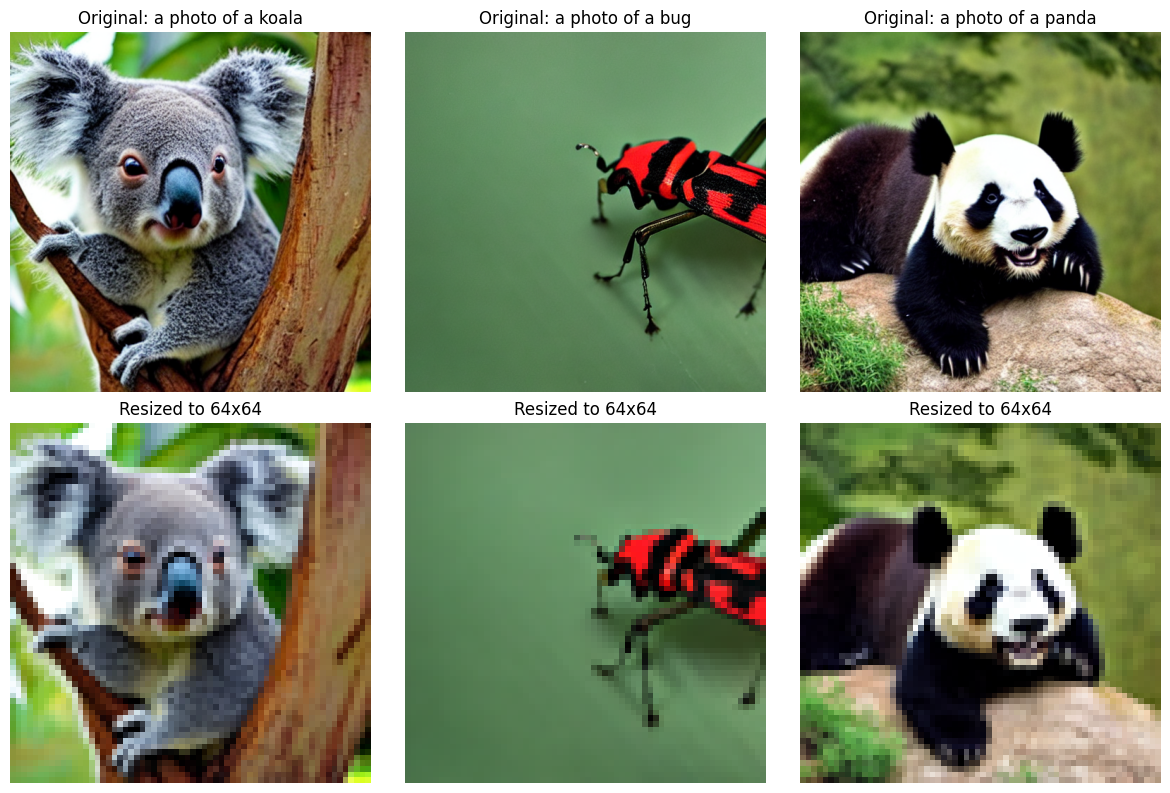

In [14]:
# 繪製原始圖片和調整後圖片
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i, (original, resized) in enumerate(zip(images, resized_images)):
    # 原始圖像
    axes[0, i].imshow(original)
    axes[0, i].set_title(f"Original: {prompts[i]}")
    axes[0, i].axis("off")
    
    # 調整後圖像
    axes[1, i].imshow(resized)
    axes[1, i].set_title("Resized to 64x64")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()


#### (d) Use the best model you identified in part (a) and the `CLIP` model from part (b) to perform inference on the three downsampled images you generated in (c). Are the results from both models correct for all three images? (5%)

In [15]:
# coding your answer here.
from tensorflow.keras.models import load_model

# 加載最佳模型
best_model = load_model("best_model.keras")


In [16]:
from tensorflow.keras.utils import img_to_array
import numpy as np
import torch

# 將 PIL 圖片轉換為 NumPy 陣列
X_images = [img_to_array(image) for image in resized_images]

# 正則化並擴展維度以符合模型輸入
X_tf = np.array(X_images) / 255.0  # 適用於 TensorFlow 模型
X_tf = np.expand_dims(X_tf, axis=0)

# 處理為 CLIP 模型格式
X_clip = [processor(images=image, return_tensors="pt") for image in resized_images]


In [19]:
# 正規化並轉換圖像數據
X_tf = np.array(X_images) / 255.0  # 確保圖像數據縮放到 [0, 1]

# 使用 TensorFlow 模型進行推理
predictions_tf = best_model.predict(X_tf)
predicted_classes_tf = np.argmax(predictions_tf, axis=1)
print("Predicted classes from the best model:", predicted_classes_tf)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted classes from the best model: [6 6 6]


In [20]:
# 使用 CLIP 模型進行推理
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

predicted_classes_clip = []
for clip_image in X_clip:
    image_features = model.get_image_features(**clip_image.to(device))
    logits_per_image = torch.matmul(image_features, text_features.T)
    predicted_class = logits_per_image.argmax(dim=1).item()
    predicted_classes_clip.append(predicted_class)

print("Predicted classes from the CLIP model:", predicted_classes_clip)


Predicted classes from the CLIP model: [5, 1, 7]


> Ans: *double click here to answer the question.*

在(a)部分識別的最佳模型預測皆為orange, 和三張圖片都不相同
但是CLIP模型對三張圖片都是預測正確的!

### (e) Use [`KerasTuner`](https://keras.io/keras_tuner/) to Perform Network Architecture Search. The search space is described as follows (15%):

|        | Type                | Activation | Notice|
|--------|---------------------|---------|------------|
| Output | Fully connected    | Softmax    ||
| D1 | DropOut     |        ||
| F1     | Fully connected         | ReLu ||
| FL     | Flatten              |            ||
| ...     |  |                  |The convoltion blocks may repeat 1~3 times|
| P1     | Max pooling     |------------|\||
| R2     | ReLu         ||\||
| B2     | batch normalization ||\||
| C2     | Convolution     ||\|-------> These 7 layer forms 1 convolution blocks|
| R1     | ReLu         ||\||
| B1     | batch normalization ||\||
| C1     | Convolution      |------------|\||
| In     | Input         |           ||

1. **Number of Convolutional Blocks:** Search for the number of convolutional blocks (each block consists of seven layers: (Convolution, Batch Normalization, ReLU) × 2 followed by a pooling layer) from 1 to 3. Fix the filter size to 3 for the convolution layer.
2. **Number of Filters:** Search for the number of filters used in the convolutional layers within the convolutional blocks from 16 to 96, with a step size of 16.
3. **Number of Neurons in Dense Layer:** Search for the number of neurons in the first dense layer from 20 to 50, with a step size of 10.
4. **Dropout Rate:** Search for the dropout rate from 0.3 to 0.8, with a step size of 0.1.
5. **Learning Rate:** Use the Adam optimizer and search for the learning rate from 0.0001 to 0.01, using a logarithmic sampling strategy with a step size of 10.

Use Bayesian optimization to conduct a maximum of 3 trials with two executions per trial. Evaluate the performance on the entire validation set for 10 epochs during the search.

Finally, use the architecture you identified and report the test accuracy achieved with this architecture.

In [22]:
# coding your answer here.
import tensorflow as tf
from tensorflow.keras import layers, models
from keras_tuner import BayesianOptimization


In [23]:
def build_model(hp):
    # 定義輸入層
    inputs = layers.Input(shape=(64, 64, 3))
    x = inputs

    # 搜尋卷積塊數量
    for i in range(hp.Int("conv_blocks", 1, 3)):
        # 每個卷積塊的濾波器數量
        filters = hp.Int(f"filters_{i+1}", 16, 96, step=16)

        for _ in range(2):  # (卷積層、批標準化層、ReLU) × 2
            x = layers.Conv2D(filters, kernel_size=3, padding="same", activation=None)(x)
            x = layers.BatchNormalization()(x)
            x = layers.ReLU()(x)

        # 最大池化層
        x = layers.MaxPooling2D(pool_size=2)(x)

    # 展平層
    x = layers.Flatten()(x)

    # 搜尋全連接層神經元數量
    x = layers.Dense(hp.Int("dense_units", 20, 50, step=10), activation="relu")(x)

    # 搜尋 Dropout 比率
    x = layers.Dropout(hp.Float("dropout_rate", 0.3, 0.8, step=0.1))(x)

    # 輸出層
    outputs = layers.Dense(10, activation="softmax")(x)

    # 編譯模型
    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Float("learning_rate", 1e-4, 1e-2, sampling="log")
        ),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


In [24]:
from keras_tuner.tuners import BayesianOptimization

# 配置調諧器
tuner = BayesianOptimization(
    build_model,
    objective="val_accuracy",
    max_trials=3,
    executions_per_trial=2,
    directory="tuner_dir",
    project_name="cnn_architecture_search",
)

# 調用調諧器
tuner.search(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10,
    verbose=1,
)


Trial 3 Complete [00h 13m 33s]
val_accuracy: 0.6959999799728394

Best val_accuracy So Far: 0.6959999799728394
Total elapsed time: 00h 34m 06s


In [25]:
# 獲取最佳模型
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# 使用最佳超參數構建模型
best_model = tuner.hypermodel.build(best_hps)

# 訓練最佳模型
best_model.fit(train_dataset, validation_data=validation_dataset, epochs=10)

# 在測試集上評估
test_loss, test_accuracy = best_model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy:.2%}")


Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 42s 247ms/step - accuracy: 0.1619 - loss: 2.3351 - val_accuracy: 0.3680 - val_loss: 1.9529
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 39s 247ms/step - accuracy: 0.3712 - loss: 1.7837 - val_accuracy: 0.4280 - val_loss: 1.5397
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 39s 247ms/step - accuracy: 0.4565 - loss: 1.5246 - val_accuracy: 0.5960 - val_loss: 1.2980
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 39s 246ms/step - accuracy: 0.5291 - loss: 1.3460 - val_accuracy: 0.5880 - val_loss: 1.1409
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 39s 248ms/step - accuracy: 0.5756 - loss: 1.2622 - val_accuracy: 0.6320 - val_loss: 1.1378
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 39s 249ms/step - accuracy: 0.6025 - loss: 1.1203 - val_accuracy: 0.6360 - val_loss: 1.1103
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 39s 247ms/step - accuracy: 0.6352 - loss: 1.0489 - val_accuracy: 0.6400 - val_loss: 1.0971
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 39s 248ms/step - accuracy: 0.6576 - loss: 0

> Ans: *double click here to answer the question.*

準確率Test Accuracy: 66.40%

## Q2: Analyze Sentiment Dataset Using Different Models


[Sentiment Analysis](https://huggingface.co/tasks/text-classification) is a subfield of Natural Language Processing (NLP) that involves determining the emotional tone behind words. Its purpose is to understand the attitudes, opinions, and emotions of a speaker or writer with respect to a specific topic or the overall contextual polarity of a document. In this problem, we will use datasets sourced from three different websites: `imdb.com`, `amazon.com`, and `yelp.com`. We will classify each sentence as positive (1) or negative (0).

Firstly, execute the following code cell to import the datasets and organize them into a unified dataset. Feel free to modify the code if you prefer to use `PyTorch` or other frameworks.

To ensure reproducibility, please set all the random seeds to 2024:

In [ ]:
!gdown --fuzzy https://drive.google.com/file/d/1E_l4Mh3OU6tRJWXFVrtXaHV-FN6j0Urm/view?usp=sharing
!unzip -qq /content/nlp_data.zip

In [29]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

filepath_dict = {'yelp':  'nlp_data/yelp_labelled.txt',
          'amazon': 'nlp_data/amazon_cells_labelled.txt',
          'imdb':  'nlp_data/imdb_labelled.txt'}

df_list = []
for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, names=['sentence', 'label'], sep='\t')
    df['source'] = source
    df_list.append(df)

df = pd.concat(df_list)
sentences = df['sentence'].to_numpy()
y = df['label'].to_numpy()

sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.3, random_state=2024)

train_ds = tf.data.Dataset.from_tensor_slices((sentences_train, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((sentences_test, y_test))
# For perfect shuffling, a buffer size greater than or equal to the full size of the dataset is required.
train_ds = train_ds.shuffle(3000).batch(32)
val_ds = val_ds.batch(32)
text_only_train_ds = train_ds.map(lambda x, y: x)

#### (a) The Bag-of-Words model is a popular approach in NLP for representing text data, and we will use this model first. (10%)

1. **Build Text Representation:** Create representations of the input text using bigrams with different encoding methods (multi-hot, count, and TF-IDF). Set the maximum number of tokens to 10,000 during vectorization to obtain a 5,000-dimensional vector for each sample.

2. **Construct Classifier:** Build a Random Forest classifier with `n_estimators` set to 10.

3. **Compare Encoding Methods:** Use the model and the accuracy metric to compare the multi-hot, count, and TF-IDF encoding methods. Determine which encoding method performs best based on validation accuracy.

**Hint:** Refer to our lab to learn how to use the `TextVectorization` layer in `Keras` to vectorize the training and validation sets. If you are using `PyTorch`, you may find `torchtext` and `TfidfVectorizer` from `sklearn` useful.

In [34]:
# coding your answer here.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# 二元語法向量化器（multi-hot 和 count 共用）
count_vectorizer = CountVectorizer(ngram_range=(2, 2), max_features=5000, binary=False)
multi_hot_vectorizer = CountVectorizer(ngram_range=(2, 2), max_features=5000, binary=True)

# TF-IDF 向量化器
tfidf_vectorizer = TfidfVectorizer(ngram_range=(2, 2), max_features=5000)

# 向量化訓練集和測試集
X_train_multi_hot = multi_hot_vectorizer.fit_transform(sentences_train)
X_test_multi_hot = multi_hot_vectorizer.transform(sentences_test)

X_train_count = count_vectorizer.fit_transform(sentences_train)
X_test_count = count_vectorizer.transform(sentences_test)

X_train_tfidf = tfidf_vectorizer.fit_transform(sentences_train)
X_test_tfidf = tfidf_vectorizer.transform(sentences_test)


In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# 定義隨機森林分類器
rf_model = RandomForestClassifier(n_estimators=10, random_state=2024)

# 訓練和測試 multi-hot 表示
rf_model.fit(X_train_multi_hot, y_train)
y_pred_multi_hot = rf_model.predict(X_test_multi_hot)
accuracy_multi_hot = accuracy_score(y_test, y_pred_multi_hot)

# 訓練和測試 count 表示
rf_model.fit(X_train_count, y_train)
y_pred_count = rf_model.predict(X_test_count)
accuracy_count = accuracy_score(y_test, y_pred_count)

# 訓練和測試 TF-IDF 表示
rf_model.fit(X_train_tfidf, y_train)
y_pred_tfidf = rf_model.predict(X_test_tfidf)
accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)


In [36]:
# 打印結果
print(f"Multi-hot Encoding Accuracy: {accuracy_multi_hot:.2%}")
print(f"Count Encoding Accuracy: {accuracy_count:.2%}")
print(f"TF-IDF Encoding Accuracy: {accuracy_tfidf:.2%}")

# 確定最佳方法
best_accuracy = max(accuracy_multi_hot, accuracy_count, accuracy_tfidf)
if best_accuracy == accuracy_multi_hot:
    best_method = "Multi-hot Encoding"
elif best_accuracy == accuracy_count:
    best_method = "Count Encoding"
else:
    best_method = "TF-IDF Encoding"

print(f"The best encoding method is: {best_method}")


Multi-hot Encoding Accuracy: 64.00%
Count Encoding Accuracy: 65.58%
TF-IDF Encoding Accuracy: 63.76%
The best encoding method is: Count Encoding


> Ans: *double click here to answer the question.*

1. 哪種編碼方法表現最佳？

A:Count Encoding 表現最佳，其驗證準確率為 65.58%。

2. 為什麼 Count Encoding 優於其他方法？

A: Count Encoding 通過記錄特徵的頻率，保留了更多的文本信息。而Multi-hot Encoding 只關注詞語是否出現，忽略了詞頻的重要性。加上TF-IDF 編碼在降低高頻詞權重時可能過度平滑，損失了一些對情感分析重要的高頻特徵。


#### (b) Now we will try to improve the performance by tuning the hyperparameters using [`Optuna`](https://optuna.org/). (10%)

1. **Define the Parameter Grid:**  
   ```python
   param_grid = {
       'n_estimators': (10, 50),
       'criterion': ['gini', 'entropy'],
       'min_samples_split': (2, 4),
       'max_features': ['sqrt', 'log2']
   }
   ```

2. **Perform Hyperparameter Search:**  
   Use Bayesian optimization with [`GPSampler`](https://optuna.readthedocs.io/en/stable/reference/samplers/generated/optuna.samplers.GPSampler.html) to search for the best hyperparameters. Treat `n_estimators` and `min_samples_split` as integer parameters, and `criterion` and `max_features` as categorical parameters. Perform cross-validation with 5 folds during the search.

3. **Construct and Evaluate the Model:**  
   Build the Random Forest classifier using the best hyperparameters found in step 2. Report the accuracy on the validation set.

**Hint:** Refer to the [`Optuna` documentation](https://optuna.readthedocs.io/en/stable/index.html) or our lab for guidance on setting up the sampler and defining the search space. Ensure that cross-validation is properly integrated into the hyperparameter tuning process to obtain reliable performance estimates.

In [43]:
# coding your answer here.
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

def objective(trial):
    # 定義參數搜尋空間
    n_estimators = trial.suggest_int('n_estimators', 10, 50)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    min_samples_split = trial.suggest_int('min_samples_split', 2, 4)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])

    # 構建隨機森林分類器
    rf_model = RandomForestClassifier(
        n_estimators=n_estimators,
        criterion=criterion,
        min_samples_split=min_samples_split,
        max_features=max_features,
        random_state=2024
    )

    # 執行 5 折交叉驗證
    scores = cross_val_score(rf_model, X_train_tfidf, y_train, cv=5, scoring='accuracy')

    # 返回交叉驗證的平均準確率
    return np.mean(scores)


In [44]:
sampler = optuna.samplers.GPSampler()
study = optuna.create_study(direction='maximize', sampler=sampler)

# 開始搜尋最佳超參數
study.optimize(objective, n_trials=30)  # 試驗次數為 30

# 輸出最佳超參數
print("Best parameters found by Optuna:")
print(study.best_params)

# 使用最佳超參數構建模型並進行評估
best_params = study.best_params
best_rf_model = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    criterion=best_params['criterion'],
    min_samples_split=best_params['min_samples_split'],
    max_features=best_params['max_features'],
    random_state=2024
)

# 在訓練集上訓練模型
best_rf_model.fit(X_train_tfidf, y_train)

# 在驗證集上評估
val_accuracy = best_rf_model.score(X_test_tfidf, y_test)
print(f"Validation Accuracy: {val_accuracy:.2%}")


C:\Users\User\AppData\Local\Temp\ipykernel_20392\1774232744.py:1: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  sampler = optuna.samplers.GPSampler()
[I 2024-12-10 21:29:06,557] A new study created in memory with name: no-name-f55d127b-f456-417d-b35b-a88db39822d4
[I 2024-12-10 21:29:10,596] Trial 0 finished with value: 0.6609375 and parameters: {'n_estimators': 42, 'criterion': 'entropy', 'min_samples_split': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.6609375.
[I 2024-12-10 21:29:15,378] Trial 1 finished with value: 0.6624972943722944 and parameters: {'n_estimators': 50, 'criterion': 'gini', 'min_samples_split': 4, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.6624972943722944.
[I 2024-12-10 21:29:17,027] Trial 2 finished with value: 0.6583603896103896 and parameters: {'n_estimators': 20, 'criterion': 'entropy', 'min_samples_split': 3, 'max_features': 'log2'}. Best is trial 1 with value: 0.66249

Best parameters found by Optuna:
{'n_estimators': 28, 'criterion': 'gini', 'min_samples_split': 2, 'max_features': 'log2'}
Validation Accuracy: 65.70%


> Ans: *double click here to answer the question.*
最佳超參數：

n_estimators: 28

criterion: gini

min_samples_split: 2

max_features: log2

驗證集準確率：

最佳模型在驗證集上的準確率為 65.70%
使用 Optuna 進行超參數優化後，模型性能提升了約 0.12%（從初始 Count 編碼方法的 65.58% 提升至 65.70%）通過貝葉斯優化自動調整超參數，能夠更高效地探索參數空間。

#### (c) We will now proceed with a sequence model. To determine the maximum length used in the vectorizer, draw a histogram showing the distribution of the number of words in each sentence in the dataset. Furthermore, calculate the average number of words and the 95% quantile of the word counts, and label them on the plot. (10%)

In [45]:
# coding your answer here
# 計算每個句子的單詞數
word_counts = [len(sentence.split()) for sentence in df['sentence']]

# 計算平均值和 95% 分位數
average_word_count = np.mean(word_counts)
quantile_95 = np.percentile(word_counts, 95)

print(f"Average word count: {average_word_count:.2f}")
print(f"95% quantile: {quantile_95:.0f}")


Average word count: 13.01
95% quantile: 26


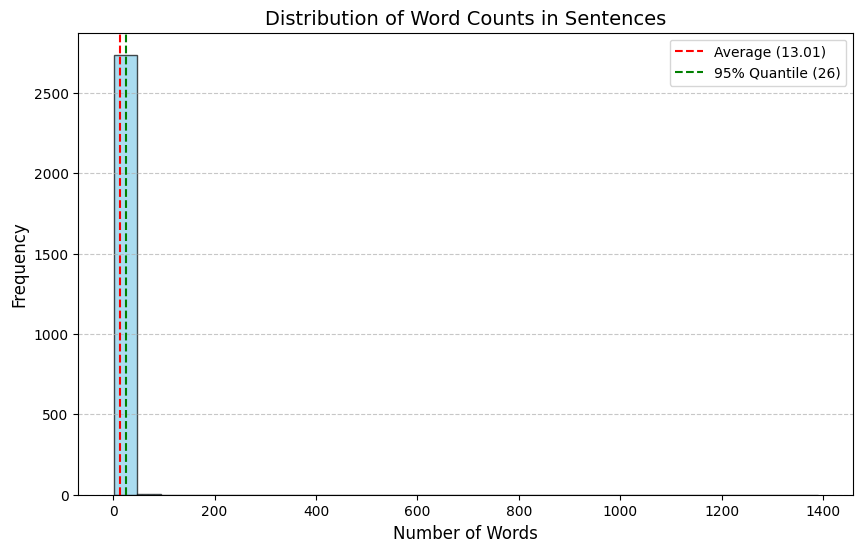

In [46]:
import matplotlib.pyplot as plt

# 繪製直方圖
plt.figure(figsize=(10, 6))
plt.hist(word_counts, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(x=average_word_count, color='red', linestyle='--', label=f'Average ({average_word_count:.2f})')
plt.axvline(x=quantile_95, color='green', linestyle='--', label=f'95% Quantile ({quantile_95:.0f})')

# 添加標籤和標題
plt.title('Distribution of Word Counts in Sentences', fontsize=14)
plt.xlabel('Number of Words', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 顯示圖表
plt.show()


#### (d) (10%)

1. **Set Maximum Length:** Set the maximum length to 10,000 when vectorizing the text and use the 95th percentile of the number of words in the sentences identified in part (c) as the maximum token length.

2. **Build an RNN Model:** Construct a Recurrent Neural Network (RNN) with the following architecture:

|        | Type                | Channels    | Activation | Notice|
|--------|---------------------|---------|------------|------------|
| Output | Fully connected     |       | Sigmoid    | Binary classification|
| D1     | Dropout |         |            |with dropout rate set to 0.8|
| R1     | Bidirectional RNN  with GRU cell        | 8      |        |Bidirectional RNN layer with 8 GRU cells|
| E1     | Embedding         |       |        | Output of embedding is set to 8 dimensions and remember to mask the padded zeros |
| In     | Input               |  |            |Input is truncated to x words with 10,000 dimensions |                                        |

3. **Compile and Train the Model:**  
    - Add a callback to monitor the validation loss and save the best model based on **validation accuracy**.
    - Compile the model using the `Adam` optimizer with the default learning rate.
    - Fit the model for 10 epochs.

4. **Evaluate the Model:**  
    - Report the accuracy on the validation set.
    - Compare this accuracy to the results obtained in part (b) and provide comments on the performance differences.

**Hint:** Refer to our lab to learn how to use the `TextVectorization` layer in `Keras` to vectorize the training and validation sets. If you are using `PyTorch`, you may find `torchtext` useful.

In [47]:
# coding your answer here.
from tensorflow.keras.layers import TextVectorization

# 設置最大長度和向量化器
max_tokens = 10000
max_len = int(quantile_95)  # 使用 95% 分位數作為最大長度

text_vectorizer = TextVectorization(max_tokens=max_tokens, output_sequence_length=max_len)

# 適配訓練數據
text_vectorizer.adapt(sentences_train)

# 向量化訓練和測試數據
X_train_vec = text_vectorizer(sentences_train)
X_test_vec = text_vectorizer(sentences_test)


In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, Dense, Dropout

# 定義模型
model = Sequential([
    # 嵌入層，輸出維度為 8，並掩碼填充零
    Embedding(input_dim=max_tokens, output_dim=8, input_length=max_len, mask_zero=True),
    
    # 雙向 GRU 層，包含 8 個單元
    Bidirectional(GRU(8)),
    
    # Dropout 層
    Dropout(0.8),
    
    # 全連接輸出層
    Dense(1, activation='sigmoid')
])


c:\Users\User\anaconda3\envs\datascience\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [51]:
from tensorflow.keras.callbacks import ModelCheckpoint

# 定義回調函數
checkpoint = ModelCheckpoint('best_rnn_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')

# 編譯模型
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 訓練模型
history = model.fit(
    X_train_vec, y_train,
    validation_data=(X_test_vec, y_test),
    epochs=10,
    batch_size=32,
    callbacks=[checkpoint]
)


Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.5222 - loss: 0.6928 - val_accuracy: 0.5758 - val_loss: 0.6918
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5459 - loss: 0.6890 - val_accuracy: 0.6182 - val_loss: 0.6877
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6151 - loss: 0.6793 - val_accuracy: 0.6618 - val_loss: 0.6740
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7610 - loss: 0.6445 - val_accuracy: 0.7418 - val_loss: 0.5927
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8579 - loss: 0.4809 - val_accuracy: 0.7782 - val_loss: 0.5078
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9111 - loss: 0.3021 - val_accuracy: 0.7976 - val_loss: 0.4995
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9400 - loss: 0.2156 - val_accuracy: 0.7976 - val_loss: 0.5133
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9610 - loss: 0.1521 - val_accuracy: 0.7939 - v

In [53]:
from tensorflow.keras.models import load_model

# 加載最佳模型
best_model = load_model('best_rnn_model.keras')

# 評估模型性能
val_accuracy = best_model.evaluate(X_test_vec, y_test, verbose=0)[1]
print(f"Validation Accuracy: {val_accuracy:.2%}")

# 與 (b) 部分結果比較
print(f"Improvement over Random Forest: {val_accuracy - 0.6570:.2%}")


Validation Accuracy: 80.97%
Improvement over Random Forest: 15.27%


> Ans: *double click here to answer the question.*

驗證集準確率：80.97%
RNN 模型在驗證集上達到了 80.97% 的準確率，相較於隨機森林的 65.70% 提升了 15.27%。

1. 為什麼 RNN 模型的性能顯著提升？
順序學習能力：RNN 模型（特別是雙向 GRU）能夠捕捉文本的上下文和順序信息，而隨機森林只考慮了特徵的獨立性。
嵌入層的作用：嵌入層將文本轉換為稠密向量表示，能更有效地學習語義特徵。
雙向 RNN：雙向 GRU 同時學習文本的前向和後向上下文，大幅提升了模型的理解能力。

2. Dropout 的貢獻
高 Dropout 比率 (0.8)：在避免過擬合的同時，使模型學習到更通用的特徵，進一步提高了驗證集的性能。

#### (e) Generative Pre-trained Transformer (GPT) is a powerful pretrained foundation model that can generate text based on the [Transformer](https://transformer.realcat.top/). (10%)

1. **Load the Model and Tokenizer:**  
   Load the model and tokenizer using the checkpoint [`gpt2-xl`](https://huggingface.co/gpt2-xl) from Hugging Face.

2. **Generate a Positive Review:**  
   Design a prompt and use the `generate()` method to produce 30 tokens that represent a positive review. For example, you can input the text "The movie is great since" and allow the model to generate 30 tokens.

3. **Classify the Generated Review:**  
   Feed the generated review into the best model identified in parts (a) and (c). Determine whether the model predicts the review as positive.

**Hint:** You can adjust parameters such as `do_sample`, `top_k`, `num_beams`, or `temperature` in the `generate()` function to make the generated text more convincing. Refer to our lab for a brief introduction. You may also find the [Transformer Explainer](https://transformer.realcat.top/) useful for understanding GPT.

In [56]:
# coding your answer here.
from transformers import GPT2Tokenizer, GPT2LMHeadModel

# 加載分詞器和模型
tokenizer = GPT2Tokenizer.from_pretrained("gpt2-xl")
model = GPT2LMHeadModel.from_pretrained("gpt2-xl")


model.safetensors:   0%|          | 0.00/6.43G [00:00<?, ?B/s]

In [61]:
# 設定提示文本
prompt = "The movie is great since"

# 分詞並生成文本
inputs = tokenizer(prompt, return_tensors="pt")
output = model.generate(
    inputs.input_ids,
    max_length=30 + len(inputs.input_ids[0]),  # 提示長度 + 30 tokens
    do_sample=True,  # 隨機采樣
    top_k=50,  # 考慮概率最高的 50 個單詞
    temperature=0.7,  # 控制生成文本的多樣性
    num_beams=5,  # 使用 beam search
    pad_token_id=tokenizer.eos_token_id  # 設置 pad_token_id
)

# 解碼生成的文本
generated_review = tokenizer.decode(output[0], skip_special_tokens=True)
print("Generated Review:")
print(generated_review)


Generated Review:
The movie is great since it has a lot of action scenes, but it also has a lot of character development. It's not just about the action, it's about the


In [62]:
# 使用與隨機森林一致的向量化器進行處理
generated_review_vec = tfidf_vectorizer.transform([generated_review])

# 使用隨機森林模型分類
rf_prediction = rf_model.predict(generated_review_vec)
rf_result = "Positive" if rf_prediction[0] == 1 else "Negative"
print(f"Random Forest Model Prediction: {rf_result}")


Random Forest Model Prediction: Positive


In [63]:
# 使用 RNN 的文本向量化方式處理
generated_review_vec_rnn = text_vectorizer([generated_review])

# 使用 RNN 模型分類
rnn_prediction = best_model.predict(generated_review_vec_rnn)
rnn_result = "Positive" if rnn_prediction[0] >= 0.5 else "Negative"
print(f"RNN Model Prediction: {rnn_result}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
RNN Model Prediction: Positive


> Ans: *double click here to answer the question.*

分類結果中可看到隨機森林模型和RNN 模型的預測結果都是Positive，兩個模型都將該評論分類為正面，表示 GPT 生成的文本具有明顯的正面情緒特徵，讓模型容易識別。
